In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
import os

zip_file_path = '/content/gdrive/MyDrive/vison_data/archive.zip'
extract_dir = '/content/vison_data' 

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File extracted to: {extract_dir}")

File extracted to: /content/vison_data


In [ ]:
import json
import os
import shutil
import random
from tqdm import tqdm
from collections import Counter


dataset_dir = "/content/vison_data/flickr30k_images/flickr30k_images"
coco_json_path = "/content/gdrive/MyDrive/vison_data/coco_output_fixed.json"
output_dir = "/content/coco_dataset"

os.makedirs(output_dir, exist_ok=True)


In [ ]:

full_json_path = "/content/gdrive/MyDrive/vison_data/coco_output.json"
source_img_dir = "/content/vison_data/flickr30k_images/flickr30k_images"
output_dir = "/content/coco_dataset"

train_img_dir = os.path.join(output_dir, "images/train")
val_img_dir = os.path.join(output_dir, "images/val")
test_img_dir = os.path.join(output_dir, "images/test")
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)

with open(full_json_path, "r") as f:
    coco_data = json.load(f)

images = coco_data["images"]
annotations = coco_data["annotations"]
categories = coco_data["categories"]

id_to_class = {cat["id"]: cat["name"] for cat in categories}

random.seed(42)
random.shuffle(images)
total = len(images)
train_end = int(total * 0.8)
val_end = int(total * 0.9)

train_images = images[:train_end]
val_images = images[train_end:val_end]
test_images = images[val_end:]

train_ids = {img["id"] for img in train_images}
val_ids = {img["id"] for img in val_images}
test_ids = {img["id"] for img in test_images}

train_annotations = [ann for ann in annotations if ann["image_id"] in train_ids]
val_annotations = [ann for ann in annotations if ann["image_id"] in val_ids]
test_annotations = [ann for ann in annotations if ann["image_id"] in test_ids]

def count_classes(annotations):
    counter = Counter()
    for ann in annotations:
        counter[id_to_class[ann["category_id"]]] += 1
    return counter

train_counts = count_classes(train_annotations)
val_counts = count_classes(val_annotations)
test_counts = count_classes(test_annotations)

print("\n Annotation Counts:")
print("Train:", train_counts)
print("Val:  ", val_counts)
print("Test: ", test_counts)

def calc_weights(counter):
    total = sum(counter.values())
    return {cls: round(total / count, 2) for cls, count in counter.items()}

weights = calc_weights(train_counts)
print("\n Class Weights (for loss):")
for cls, w in weights.items():
    print(f"{cls}: {w}")

splits = {
    "train": (train_images, train_annotations),
    "val": (val_images, val_annotations),
    "test": (test_images, test_annotations),
}
for split_name, (imgs, anns) in splits.items():
    out_json = {
        "images": imgs,
        "annotations": anns,
        "categories": categories
    }
    with open(os.path.join(output_dir, f"annotations_{split_name}.json"), "w") as f:
        json.dump(out_json, f, indent=2)

def copy_images(image_list, target_folder):
    for img in tqdm(image_list, desc=f"Copying to {target_folder}"):
        src = os.path.join(source_img_dir, img["file_name"])
        dst = os.path.join(target_folder, img["file_name"])
        if os.path.exists(src):
            shutil.copy2(src, dst)
        else:
            print(f" Missing image: {img['file_name']}")

copy_images(train_images, train_img_dir)
copy_images(val_images, val_img_dir)
copy_images(test_images, test_img_dir)

print("\n Train/Val/Test split complete. JSONs and image folders are ready.")



📊 Annotation Counts:
Train: Counter({'human': 35164, 'pet': 1293})
Val:   Counter({'human': 4479, 'pet': 146})
Test:  Counter({'human': 4036, 'pet': 160})

⚖️ Class Weights (for loss):
human: 1.04
pet: 28.2


Copying to /content/coco_dataset/images/test: 100%|██████████| 954/954 [00:02<00:00, 445.12it/s]


✅ Train/Val/Test split complete. JSONs and image folders are ready.


In [ ]:
with open("/content/coco_dataset/yolo_pet_human.yaml", "w") as f:
    f.write("""
path: /content/coco_dataset
train: images/train
val: images/val

names:
  0: human
  1: pet
""")

In [ ]:
import os
import json
from tqdm import tqdm

def convert_coco_to_yolo(coco_path, split='train', output_dir='/content/coco_dataset'):
    with open(coco_path, 'r') as f:
        coco = json.load(f)

    img_id_to_filename = {img['id']: img['file_name'] for img in coco['images']}
    class_map = {0: 'human', 1: 'pet'} 
    category_id_to_index = {}

    for cat in coco['categories']:
        if cat['name'] in class_map.values():
            category_id_to_index[cat['id']] = list(class_map.values()).index(cat['name'])

    labels_dir = os.path.join(output_dir, 'labels', split)
    os.makedirs(labels_dir, exist_ok=True)

    image_dims = {img['id']: (img['width'], img['height']) for img in coco['images']}
    img_to_anns = {}

    for ann in coco['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_anns:
            img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)

    for img_id, anns in tqdm(img_to_anns.items(), desc=f"Processing {split} annotations"):
        file_name = img_id_to_filename[img_id]
        width, height = image_dims[img_id]
        label_file = os.path.join(labels_dir, os.path.splitext(file_name)[0] + '.txt')

        lines = []
        for ann in anns:
            cat_id = ann['category_id']
            if cat_id not in category_id_to_index:
                continue

            x, y, w, h = ann['bbox']
            xc = (x + w / 2) / width
            yc = (y + h / 2) / height
            norm_w = w / width
            norm_h = h / height

            cls = category_id_to_index[cat_id]
            lines.append(f"{cls} {xc:.6f} {yc:.6f} {norm_w:.6f} {norm_h:.6f}")

        if lines:
            with open(label_file, 'w') as f:
                f.write('\n'.join(lines))

convert_coco_to_yolo('/content/coco_dataset/annotations_train.json', split='train')
convert_coco_to_yolo('/content/coco_dataset/annotations_val.json', split='val')


Processing val annotations: 100%|██████████| 944/944 [00:00<00:00, 19148.74it/s]


In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

human_weight = weights['human']
pet_weight = weights['pet']



100%|██████████| 5.35M/5.35M [00:00<00:00, 95.3MB/s]


In [ ]:
model.train(
    data="/content/coco_dataset/yolo_pet_human.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="augmented_run",
    project="human_pet_detect",
    hsv_h=0.02,
    hsv_s=0.6,
    hsv_v=0.4,
    fliplr=0.5,
    scale=0.6,
    translate=0.1,
    degrees=5.0,
    mosaic=1.0,
    mixup=0.0,
    erasing=0.2,
    val=True,
    plots=True
)

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/coco_dataset/yolo_pet_human.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.2, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.6, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=augmented_run2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

train: Scanning /content/coco_dataset/labels/train.cache... 7568 images, 59 backgrounds, 0 corrupt: 100%|██████████| 7627/7627 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 923.3±967.1 MB/s, size: 120.3 KB)


val: Scanning /content/coco_dataset/labels/val.cache... 944 images, 9 backgrounds, 0 corrupt: 100%|██████████| 953/953 [00:00<?, ?it/s]


Plotting labels to human_pet_detect/augmented_run2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to human_pet_detect/augmented_run2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.92G      1.263      1.669      1.307         81        640: 100%|██████████| 477/477 [02:43<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  3.00it/s]


                   all        953       4625      0.549      0.419      0.448      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.11G      1.383      1.457      1.408        104        640: 100%|██████████| 477/477 [02:37<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


                   all        953       4625      0.662      0.438      0.499      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.12G      1.406      1.453      1.431         83        640: 100%|██████████| 477/477 [02:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


                   all        953       4625      0.449      0.439      0.407      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.12G      1.374        1.4      1.415         75        640: 100%|██████████| 477/477 [02:33<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


                   all        953       4625      0.594      0.479      0.494      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.13G       1.34      1.359      1.395        141        640: 100%|██████████| 477/477 [02:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


                   all        953       4625      0.702      0.414      0.501      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.15G      1.314      1.318      1.373        145        640: 100%|██████████| 477/477 [02:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


                   all        953       4625      0.677      0.569      0.627      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.34G      1.293      1.274      1.356        108        640: 100%|██████████| 477/477 [02:36<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  3.95it/s]


                   all        953       4625      0.658      0.554      0.604      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.36G      1.266      1.252      1.342         84        640: 100%|██████████| 477/477 [02:34<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


                   all        953       4625      0.705      0.533      0.615      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.37G      1.257      1.229      1.334        165        640: 100%|██████████| 477/477 [02:36<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


                   all        953       4625      0.732      0.557      0.642      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.37G      1.224      1.193      1.316        107        640: 100%|██████████| 477/477 [02:34<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.21it/s]

                   all        953       4625      0.772      0.571      0.664      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.37G      1.204      1.168      1.304         88        640: 100%|██████████| 477/477 [02:38<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


                   all        953       4625      0.729      0.615      0.679      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.37G       1.19      1.162      1.293         77        640: 100%|██████████| 477/477 [02:37<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  3.93it/s]


                   all        953       4625      0.735      0.629      0.689      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.37G      1.174      1.151      1.289         75        640: 100%|██████████| 477/477 [02:36<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.31it/s]


                   all        953       4625      0.719      0.545      0.618      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.37G       1.17      1.132      1.281        125        640: 100%|██████████| 477/477 [02:36<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  3.85it/s]

                   all        953       4625      0.747       0.61      0.679      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.37G      1.157      1.121      1.276         87        640: 100%|██████████| 477/477 [02:34<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.17it/s]

                   all        953       4625       0.73      0.627      0.706      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.37G      1.142      1.102      1.265        167        640: 100%|██████████| 477/477 [02:36<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


                   all        953       4625      0.754      0.629      0.706      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.37G      1.133      1.093      1.257         98        640: 100%|██████████| 477/477 [02:36<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


                   all        953       4625      0.756      0.617      0.714      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.37G      1.126      1.083      1.255        144        640: 100%|██████████| 477/477 [02:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


                   all        953       4625      0.761      0.563      0.656      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.37G      1.118      1.067       1.25        170        640: 100%|██████████| 477/477 [02:36<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.22it/s]

                   all        953       4625      0.795      0.613      0.713      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.57G      1.102      1.054      1.239         84        640: 100%|██████████| 477/477 [02:36<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.74it/s]

                   all        953       4625      0.768      0.634      0.718      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.57G      1.091      1.042      1.238         92        640: 100%|██████████| 477/477 [02:34<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.33it/s]


                   all        953       4625      0.742      0.643      0.712      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.57G      1.086       1.03      1.228         71        640: 100%|██████████| 477/477 [02:36<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.59it/s]


                   all        953       4625      0.849      0.628       0.73      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.57G      1.083      1.024      1.226         93        640: 100%|██████████| 477/477 [02:34<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


                   all        953       4625      0.837      0.626      0.732      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.78G      1.074      1.015      1.217        130        640: 100%|██████████| 477/477 [02:39<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


                   all        953       4625      0.794      0.608      0.725      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.78G      1.073      1.015       1.22         76        640: 100%|██████████| 477/477 [02:40<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.52it/s]

                   all        953       4625      0.779      0.639      0.717      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.78G      1.064     0.9974      1.208         79        640: 100%|██████████| 477/477 [02:36<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


                   all        953       4625      0.799      0.626      0.746      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.78G      1.058     0.9973      1.209         79        640: 100%|██████████| 477/477 [02:38<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]

                   all        953       4625      0.751      0.678      0.742      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.78G      1.048     0.9782      1.201         86        640: 100%|██████████| 477/477 [02:38<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.61it/s]

                   all        953       4625      0.807      0.649      0.749      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.78G      1.034     0.9696      1.197        112        640: 100%|██████████| 477/477 [02:33<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


                   all        953       4625      0.787      0.664      0.762      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.78G      1.029      0.954       1.19        161        640: 100%|██████████| 477/477 [02:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  3.79it/s]

                   all        953       4625      0.808      0.641      0.763       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.78G      1.027     0.9496      1.191         84        640: 100%|██████████| 477/477 [02:36<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.40it/s]

                   all        953       4625      0.802      0.648      0.751      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.01G      1.022     0.9447      1.186         69        640: 100%|██████████| 477/477 [02:37<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.32it/s]


                   all        953       4625      0.798       0.66      0.737      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.01G      1.017     0.9427      1.183        126        640: 100%|██████████| 477/477 [02:36<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.72it/s]


                   all        953       4625      0.782      0.673      0.765      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.01G      1.006     0.9327      1.176         68        640: 100%|██████████| 477/477 [02:37<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


                   all        953       4625      0.799      0.649      0.754      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.01G      1.009     0.9266      1.178         78        640: 100%|██████████| 477/477 [02:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


                   all        953       4625      0.822      0.631      0.757      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.01G      1.003     0.9157      1.173        138        640: 100%|██████████| 477/477 [02:43<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


                   all        953       4625      0.804      0.658      0.756      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.01G     0.9946      0.907       1.17        120        640: 100%|██████████| 477/477 [02:42<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.17it/s]


                   all        953       4625      0.838      0.658      0.774      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.01G     0.9839     0.9052      1.165        104        640: 100%|██████████| 477/477 [02:45<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


                   all        953       4625      0.814      0.676      0.766      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.01G     0.9791     0.8922      1.159         95        640: 100%|██████████| 477/477 [02:44<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.03it/s]


                   all        953       4625      0.803      0.665      0.767      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.01G      0.978     0.8915      1.159         84        640: 100%|██████████| 477/477 [02:45<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]

                   all        953       4625      0.832      0.657      0.774       0.58


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.01G     0.8948     0.8014       1.12         41        640: 100%|██████████| 477/477 [02:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.51it/s]

                   all        953       4625      0.809      0.682      0.784      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.01G     0.8843     0.7827      1.113         32        640: 100%|██████████| 477/477 [02:34<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


                   all        953       4625      0.841      0.662       0.78      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.01G     0.8685     0.7675      1.102         58        640: 100%|██████████| 477/477 [02:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


                   all        953       4625      0.801      0.679      0.772      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.01G     0.8608     0.7562      1.098         36        640: 100%|██████████| 477/477 [02:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.03it/s]


                   all        953       4625      0.763      0.704       0.78      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.01G     0.8622     0.7571        1.1         31        640: 100%|██████████| 477/477 [02:34<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.37it/s]

                   all        953       4625      0.814      0.681      0.785      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.01G     0.8486     0.7433      1.093         46        640: 100%|██████████| 477/477 [02:33<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  3.81it/s]


                   all        953       4625      0.797      0.691       0.78      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.01G      0.845      0.733      1.088         57        640: 100%|██████████| 477/477 [02:34<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


                   all        953       4625      0.836      0.669      0.786      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.01G     0.8364     0.7215      1.081         44        640: 100%|██████████| 477/477 [02:33<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


                   all        953       4625      0.799      0.723      0.791      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.01G     0.8263     0.7162      1.078         52        640: 100%|██████████| 477/477 [02:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  3.77it/s]

                   all        953       4625      0.773      0.746      0.793      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.01G     0.8208     0.7066      1.072         35        640: 100%|██████████| 477/477 [02:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


                   all        953       4625      0.787      0.713      0.791      0.592

50 epochs completed in 2.314 hours.
Optimizer stripped from human_pet_detect/augmented_run2/weights/last.pt, 5.5MB
Optimizer stripped from human_pet_detect/augmented_run2/weights/best.pt, 5.5MB

Validating human_pet_detect/augmented_run2/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


                   all        953       4625      0.775      0.746      0.793      0.593
                 human        897       4479      0.803      0.772      0.852      0.648
                   pet         80        146      0.747      0.719      0.733      0.538
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to human_pet_detect/augmented_run2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c5d49da7fd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
best_model = YOLO("/content/human_pet_detect/augmented_run2/weights/best.pt")

metrics = best_model.val()


Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2255.2±444.6 MB/s, size: 136.1 KB)


val: Scanning /content/coco_dataset/labels/val.cache... 944 images, 9 backgrounds, 0 corrupt: 100%|██████████| 953/953 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


                   all        953       4625       0.77      0.746      0.791      0.591
                 human        897       4479      0.801      0.772      0.852      0.647
                   pet         80        146      0.739      0.719       0.73      0.535
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val


In [ ]:
from ultralytics import YOLO
best_model = YOLO("/content/human_pet_detect/augmented_run2/weights/best.pt")
best_model.predict(source="/content/coco_dataset/images/test", save=True, conf=0.25)


image 1/954 /content/coco_dataset/images/test/1000366164.jpg: 480x640 2 humans, 49.7ms
image 2/954 /content/coco_dataset/images/test/1007320043.jpg: 448x640 3 humans, 50.5ms
image 3/954 /content/coco_dataset/images/test/1010673430.jpg: 448x640 4 humans, 11.2ms
image 4/954 /content/coco_dataset/images/test/101362133.jpg: 640x448 2 humans, 63.9ms
image 5/954 /content/coco_dataset/images/test/1021293940.jpg: 640x448 3 humans, 10.0ms
image 6/954 /content/coco_dataset/images/test/102455176.jpg: 640x448 1 human, 9.8ms
image 7/954 /content/coco_dataset/images/test/1028982826.jpg: 512x640 8 humans, 49.3ms
image 8/954 /content/coco_dataset/images/test/104669470.jpg: 640x640 1 human, 10.7ms
image 9/954 /content/coco_dataset/images/test/105223874.jpg: 448x640 2 humans, 10.9ms
image 10/954 /content/coco_dataset/images/test/105493603.jpg: 448x640 4 humans, 10.6ms
image 11/954 /content/coco_dataset/images/test/1067790824.jpg: 480x640 2 pets, 11.0ms
image 12/954 /content/coco_dataset/images/test/109

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'human', 1: 'pet'}
 obb: None
 orig_img: array([[[ 62,  81, 116],
         [ 61,  80, 115],
         [ 59,  78, 113],
         ...,
         [ 89, 108, 143],
         [ 89, 108, 143],
         [ 89, 108, 143]],
 
        [[ 61,  80, 115],
         [ 61,  80, 115],
         [ 59,  78, 113],
         ...,
         [ 89, 108, 143],
         [ 89, 108, 143],
         [ 89, 108, 143]],
 
        [[ 63,  82, 117],
         [ 63,  82, 117],
         [ 62,  81, 116],
         ...,
         [ 91, 110, 145],
         [ 91, 110, 145],
         [ 91, 110, 145]],
 
        ...,
 
        [[162, 140, 122],
         [160, 138, 120],
         [156, 136, 118],
         ...,
         [ 95,  94, 144],
         [ 96,  94, 140],
         [ 99,  97, 139]],
 
        [[159, 137, 119],
         [157, 135, 117],
         [153, 133, 115],
         ...,
         

In [ ]:

from IPython.display import Image, display

image_path = "/content/coco_dataset/images/val/386655611.jpg"
display(Image(filename=image_path))


In [ ]:

from IPython.display import Image, display

image_path = "/content/runs/detect/predict/386655611.jpg"
display(Image(filename=image_path))

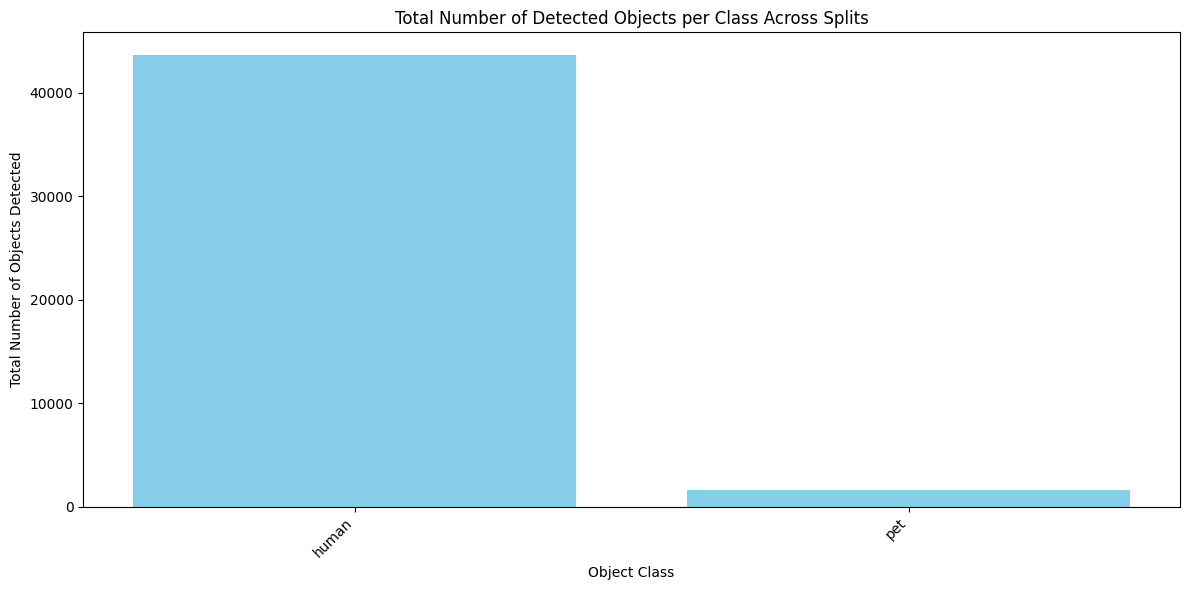

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

all_counts = Counter()
for cls in train_counts:
    all_counts[cls] += train_counts[cls]
for cls in val_counts:
    all_counts[cls] += val_counts[cls]
for cls in test_counts:
    all_counts[cls] += test_counts[cls]

labels = list(all_counts.keys())
counts = list(all_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Object Class')
plt.ylabel('Total Number of Objects Detected')
plt.title('Total Number of Detected Objects per Class Across Splits')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()